In [1]:
from random import choices

from IPython import display
import matplotlib
import matplotlib.pyplot as plt

import gym
import numpy as np
import torch

In [ ]:
class DQN():
    '''
    Deep Q-Learning Network
    
    
    Vocab:
    ------
    
    observation: immediate info provided by environment
    history: accumulation of state,action and observation
    state: F(history) to provide always same input length
    
    '''
    def __init__(self,env,hyperparams=None):
        self.epsilon = hyperparams.get('epsilon',0.5) #Exploration probability
        self.epsilon_min = hyperparams.get('epsilon_min',0.1)
        self.alpha = hyperparams.get('alpha',0.01) #Learning rate
        self.gamma = hyperparams.get('gamma',1) #Discount rate
        
        self.replay_capacity = int(hyperparams.get('N',10e2))
        self.replay_memory = [] #N x (state,action,reward,next_state)
        
        self.q = _initialize_cnn()
        self.batch_size = hyperparams.get('batch_size',32)
        
        self.history = []

    
    def _initialize_cnn(self):
        return cnn
    
    def memorize(self,observation,action,reward,next_observation):
        
        phi = _phi(self.history)
        self.history.append(observation)
        next_phi = _phi(self.history)
        
        self.replay_memory.append([phi,action,reward,next_phi])
        self.replay_memory = self.replay_memory[-self.replay_capacity:]     
    
    def act(self,observation):
        '''Epsilon-greedy policy
        '''
        state = self._phi(self.history)
        
        if np.random.uniform(0,1)<self.epsilon:
            action = env.state_space.sample()
        else:
            action = max(self.q(state))
            
        return action
    
    def learn(self,batch_size=self.batch_size):
        
        for sample in choices(self.replay_memory,k=batch_size):
            
        
        
        pass
    
    def reset(self):
        pass

In [ ]:
def _preprocess_frame(frame):
    '''
    Takes RGB image and returns cnn input.
    
    Params:
    -------

    frame: np.array, size: (210, 160, 3)
    
    Returns:
    --------
    
    np.array, size: (80,80)
    
    '''
    greyscale = np.dot(frame[...,:3], [0.2989, 0.5870, 0.1140]) #(210,160,3) -> (210,160)
    #Hard coded for breakout
    downsampled = obs_grey[::2,::2] #(210,160) -> (105,80)
    squared = obs_down[17:97:,] #(105,80) -> (80,80) , Includes the full 'play area'
    
    return squared

def _phi(history, nframes=4):
        '''Extracts current state from learned history
        '''
        frames = history[-nframes:]
        state = [_preprocess_frame(frame) for frame in frames]
        return state


In [ ]:
def train_dqn(agent,env,episodes):
    
    metrics = []
    frames = []
    
    for episode in episodes:
        observation = env.reset()
        done = False
        action = agent.act(observation)
        
        while not done:
            next_observation,done,reward,info = env.step(action)
            next_action = agent.act(observation)
            agent.learn(observation,action,reward,next_observation)
            
            observation = next_observation
            action = next_action
            
            update_metrics(metrics)
            update_frames(frames)
            
    return metrics,frames
            

In [3]:
env = gym.make('Breakout-v0')

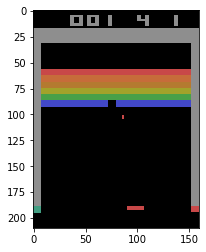

In [4]:
%matplotlib inline

env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

In [7]:
obs = env.reset()

In [40]:
obs_grey = np.dot(obs[...,:3], [0.2989, 0.5870, 0.1140])
obs_down = obs_grey[::2,::2]
obs_square = obs_down[17:97:,]

In [41]:
obs_square.shape

(80, 80)

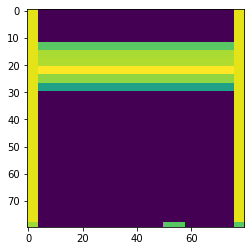

In [42]:
plt.imshow(obs_square)